## Build and train model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
import sklearn.metrics as sklmetrics
from random import sample 

import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import sklearn.metrics as metrics

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
26064,00006850_003.png,No Finding,3,6850,56,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00006850_003.png
47606,00012087_018.png,Fibrosis|Mass|Nodule,18,12087,65,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012087_018.png
39302,00010304_007.png,No Finding,7,10304,15,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010304_007.png


In [3]:
## Here we create some extra columns in the table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

## Split up "Finding Labels" column so that we have one column in my dataframe per disease, with a binary flag. 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

len(all_labels) # total should be 15: 14 common thoracic pathologies + No Finding

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


15

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification. 
## It is a dedicated class for classification.

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'yes' if x==1.0 else 'no')
# all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x)) 
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no


In [5]:
all_xray_df['pneumonia_class'].dtypes

dtype('O')

In [6]:
type(all_xray_df['pneumonia_class'][0])

str

In [7]:
# Clean data, without outliers >100 years old
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] <= 100,:] 

## Create your training and testing data:

The general rule of thumb is to split the data 80 in the training set and 20 in the validation set. The data should be split to maximize the prevalence of positive cases (i.e make sure 80% of positive cases end up in the training set and 20% in the validation set).

We want to have a balanced training set so that the model has an equal number of cases in each class to learn. Even if one class is really rare in the wild. We want to have an imbalanced validation set to reflect the real-world situation. For all other variables (age, gender, etc.) the distribution should follow the same distribution as the original full dataset, and as we saw in the EDA, Pneumonia follows the same distribution.

So thus, we want our training set to have a 50-50% proportion (50% positive and 50% negative) for our training set. For the validation dataset, we need to have an inbalanced dataset to reflect the original distribution, however the original distribution is too skewed towards the negative class (pneumonia has a relative frequency of 1.3% as shown in the EDA). So in order to keep the validation set unbalanced and still not too skewed, we will use a a 20-80% proportion (20% positive and 80% negative) for pneumonia to reflect the imbalance. 

#### 80/20 split

In [8]:
def create_splits(vargs):
    
    train_df, val_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2,    ## 80/20 ratio
                                   stratify = all_xray_df['pneumonia_class'])  ## positive cases
    
    return train_df, val_df

train_df, val_df = create_splits(all_xray_df)

In [9]:
# We check that we have a 80/20 ratio of positive cases
train_df['Pneumonia'].sum() / val_df['Pneumonia'].sum()

4.0

In [10]:
# We check the ratio in the training dataset
train_df['Pneumonia'].sum()/len(train_df)

0.012756040721206917

In [11]:
# We check the ratio in the validation dataset
val_df['Pneumonia'].sum()/len(val_df)

0.01275589848802462

Although we have 80% of positive cases in the training set and 20% in the validation set, our train_test_split made sure that we had the same proportions of pneumonia in both sets. Since we want our model to be trained on a set that has equal proportions of pneumonia and no pneumonia, we're going to throw away some data:

#### 50/50 in Training

In [12]:
## We randomly chose a set of non-Pneumonia images using the sample() function that was the same length as 
# the number of true Pneumonia cases we had, and then we threw out the rest of the non-Pneumonia cases. 

p_inds = train_df[train_df['pneumonia_class']=='yes'].index.tolist()
np_inds = train_df[train_df['pneumonia_class']=='no'].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [13]:
# Now our training dataset is balanced 50-50.
train_df['Pneumonia'].sum()/len(train_df)

0.5

#### 20/80 in Validation

In [14]:
p_inds = val_df[val_df['pneumonia_class']=='yes'].index.tolist()
np_inds = val_df[val_df['pneumonia_class']=='no'].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]

In [15]:
val_df['Pneumonia'].sum()/len(val_df)

0.2

#### Look at the distributions in each dataset

Text(0.5, 0, 'Patient Age')

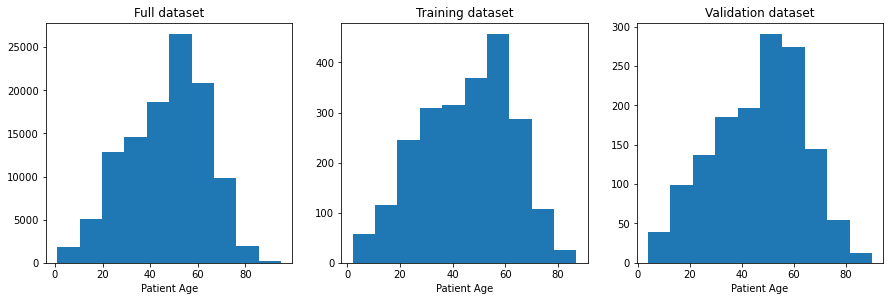

In [16]:
# Age distribution:
plt.figure(figsize=(15,15))

plt.subplot(3,3,1), plt.hist(all_xray_df['Patient Age'])
plt.title('Full dataset')
plt.xlabel('Patient Age')
plt.subplot(3,3,2), plt.hist(train_df['Patient Age'])
plt.title('Training dataset')
plt.xlabel('Patient Age')
plt.subplot(3,3,3), plt.hist(val_df['Patient Age'])
plt.title('Validation dataset')
plt.xlabel('Patient Age')

The age distributions in the training and validation datasets are similar to the one in the original dataset. 

Text(0.5, 1.0, 'Validation dataset')

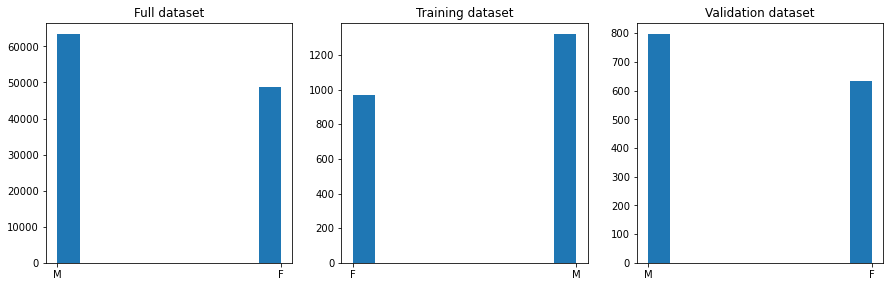

In [17]:
# Gender distribution:
plt.figure(figsize=(15,15))

plt.subplot(3,3,1), plt.hist(all_xray_df['Patient Gender'])
plt.title('Full dataset')
plt.subplot(3,3,2), plt.hist(train_df['Patient Gender'])
plt.title('Training dataset')
plt.subplot(3,3,3), plt.hist(val_df['Patient Gender'])
plt.title('Validation dataset')

The gender distributions in the training and validation datasets are similar to the one in the original dataset.

Text(0.5, 1.0, 'Validation dataset')

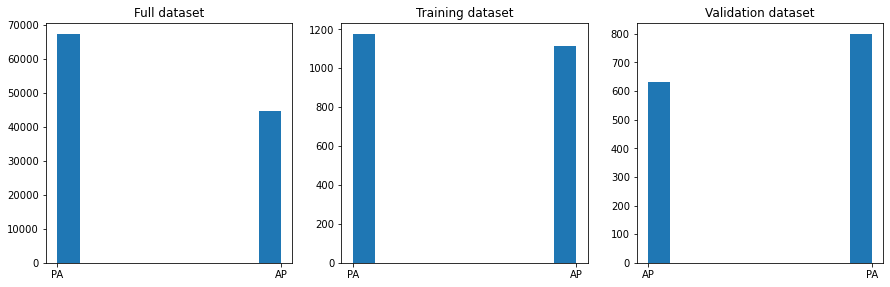

In [18]:
# Image view position distribution:
plt.figure(figsize=(15,15))

plt.subplot(3,3,1), plt.hist(all_xray_df['View Position'])
plt.title('Full dataset')
plt.subplot(3,3,2), plt.hist(train_df['View Position'])
plt.title('Training dataset')
plt.subplot(3,3,3), plt.hist(val_df['View Position'])
plt.title('Validation dataset')

The image view position distribution in the validation dataset is similar to the one in the original dataset. However, we are training the model on more AP positions than in the original dataset. This makes sense since we are training for more cases of Pneumonia, for which the AP position is preferred.

Text(0.5, 1.0, 'Validation dataset')

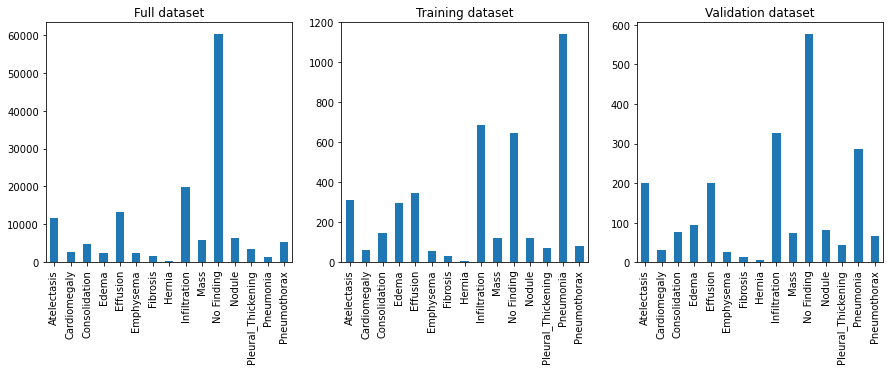

In [19]:
# Diseases distribution:
plt.figure(figsize=(15,15))

plt.subplot(3,3,1), all_xray_df[all_labels].sum().plot(kind='bar')
plt.title('Full dataset')
plt.subplot(3,3,2), train_df[all_labels].sum().plot(kind='bar')
plt.title('Training dataset')
plt.subplot(3,3,3), val_df[all_labels].sum().plot(kind='bar')
plt.title('Validation dataset')

We can see that we are training on more Pneumonia cases than in the original real-world dataset. This makes sense since we have set up the training ratio to 50/50 (positive/negative) so the model can learn well. In the validation dataset we have more Pneumonia cases than in the real-world because, as we said, the original distribution is too skewed towards the negative class so we use a 20/80 ratio to reflect the imbalance. For the other diseases the distribution is similar to the one in the original dataset.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on the data

In [20]:
def my_image_augmentation(vargs):
    
    ## Define image generator 
        
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False,   # not appropriate for medical imaging
                              height_shift_range= 0.1, # tried different values: 0.05, 0.1, 0.3, 0.5
                              width_shift_range= 0.1,  # tried different values: 0.05, 0.1, 0.3, 0.5
                              rotation_range= 20,      # tried different values: 10, 20, 30, 40
                              shear_range = 0.1,       # tried different values: 0.05, 0.1, 0.3, 0.5
                              zoom_range=0.1)          # tried different values: 0.05, 0.1, 0.3, 0.5

      
    return train_idg

train_idg = my_image_augmentation(train_df)


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for the training data
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 64
                                         )

    return train_gen

train_gen = make_train_gen(train_df)


## Rescale validation data. Note that the validation data should not be augmented! 
        
def my_val_rescale(vargs):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return val_idg

val_idg = my_val_rescale(val_df)


def make_val_gen(vargs):
    
    val_gen = val_idg.flow_from_dataframe(dataframe=val_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224, 224), ## image size
                                         batch_size = 64    ## Tried popular batch sizes: 32, 64, and 128 samples
                                         )
    
    return val_gen

val_gen = make_val_gen(val_df)

Found 2288 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [21]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

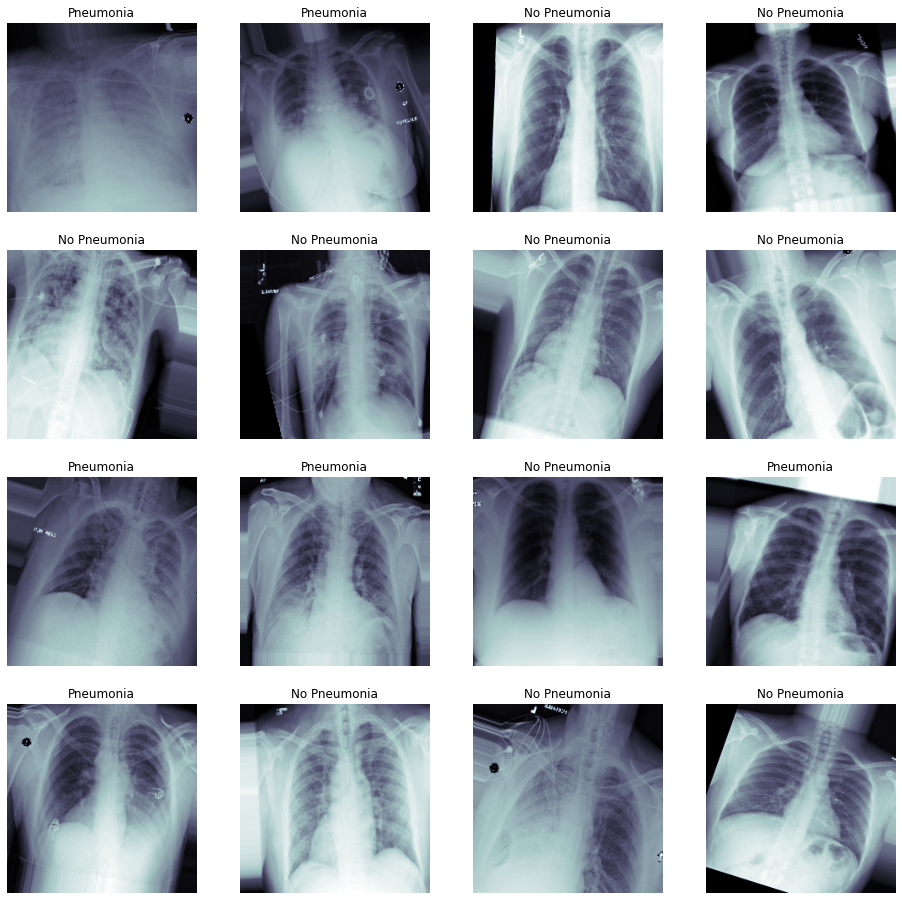

In [22]:
## May want to look at some examples of the augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [23]:
def load_pretrained_model(vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool') ## last convolutional layer (contains all convolutional layers from VGG16)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output) 
    
    return vgg_model

vgg_model = load_pretrained_model(VGG16)

553467904/553467096 [==============================] - 11s 0us/step


In [24]:
def build_my_model(vargs):
      
    my_model = Sequential()
    
    # If compiling the model within this function, consider which layers of the pre-trained model to freeze before compile.   
    # Choose which layers of VGG16 we actually want to fine-tune (if any). We'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    # Add the pre-trained model from above (convolutional part of the VGG16 model) .
    my_model.add(vgg_model)
    
    # Add whatever additional layers you think you might want for fine-tuning (Flatteen, Dense, Dropout, etc.):
    
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer. 
    
    # Add a dropout-layer which may prevent overfitting and 
    #improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # This is for combining features that the VGG16 model has recognized in the image.
    my_model.add(Dense(1024, activation='relu'))
    
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    
    # Change the activation function to sigmoid so output of the last layer is in the range of [0,1]
    my_model.add(Dense(1, activation='sigmoid'))
    
    # Make sure to set optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)  # tried with different learning rates
    loss = 'binary_crossentropy' # same than log loss
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    return my_model

my_model = build_my_model(vgg_model)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [25]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                           monitor= 'loss', # We monitor the training progress using log loss
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [26]:
## train your model
# The model has to be computed for at least 20 epochs to see visible results. Tried with epochs: 30, 40, 50.

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 30,  
                          callbacks = callbacks_list)

Epoch 1/30
36/36 [==============================] - 70s 2s/step - loss: 0.7901 - binary_accuracy: 0.5083 - val_loss: 0.8619 - val_binary_accuracy: 0.2031

Epoch 00001: loss improved from inf to 0.78945, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
36/36 [==============================] - 61s 2s/step - loss: 0.7284 - binary_accuracy: 0.5175 - val_loss: 0.6088 - val_binary_accuracy: 0.7656

Epoch 00002: loss improved from 0.78945 to 0.72883, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
36/36 [==============================] - 60s 2s/step - loss: 0.7014 - binary_accuracy: 0.5511 - val_loss: 0.6498 - val_binary_accuracy: 0.7188

Epoch 00003: loss improved from 0.72883 to 0.70112, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
36/36 [==============================] - 61s 2s/step - loss: 0.6958 - binary_accuracy: 0.5612 - val_loss: 0.6211 - val_binary_accuracy: 0.6875

Epoch 00004: loss improved from 0.70112 to 0.69577, saving model to xray_class_my_model.be

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [27]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 64, verbose = True) # Batch size - try: 32, 64, 128, 256

64/64 [==============================] - 1s 10ms/step


In [28]:
# Function to plot the roc_curve. We use scikit-learn's built in functions: roc_curve
def plot_auc(t_y, p_y):
    
    fpr, tpr, _ = sklmetrics.roc_curve(t_y, p_y)
    roc_auc = sklmetrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label='AUC=%0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('Flase Positive Rate')
    plt.show()
    
    return fpr, tpr, roc_auc
    
# Function to plot the precision_recall_curve.
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = sklmetrics.precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', sklmetrics.average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
    return precision, recall, thresholds

# Function to calculate the F1 score
def calc_f1(precision, recall):
    f1_score = 2*(precision*recall)/(precision+recall)
    return f1_score

# Plot the history of your model training: loss, val_loss, binary_accuracy, and val_binary_accuracy over all epochs. 
def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
      
    return

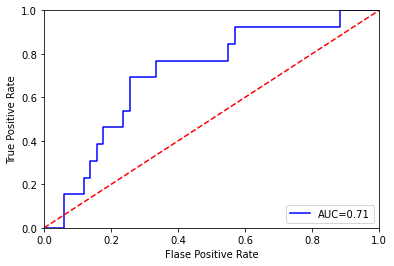

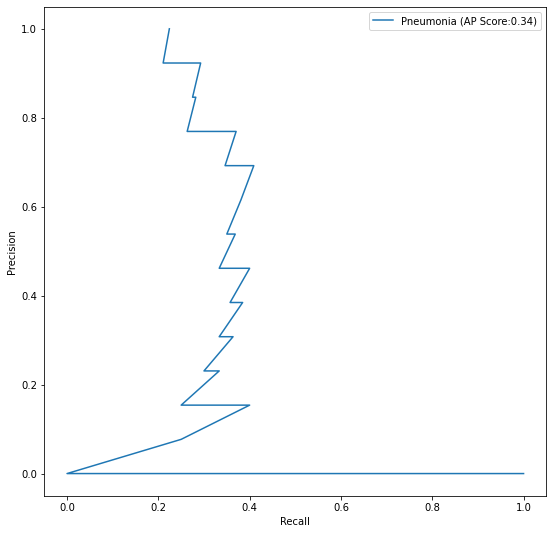

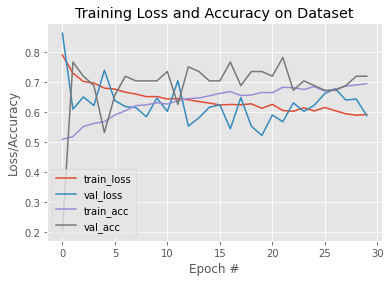

In [29]:
## plot figures

# plot ROC curve
plot_auc(valY,pred_Y)

# plot precision_recall
plot_precision_recall_curve(valY,pred_Y)

# plot history
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [30]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize
precision, recall, thresholds = sklmetrics.precision_recall_curve(valY, pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)
    
print('Maximum F1-Score: ', np.max(f1_scores))
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Corresponding precision:', precision[np.argmax(f1_scores)])
print('Corresponding recall:', recall[np.argmax(f1_scores)])

Maximum F1-Score:  0.5142857142857142
Best threshold:  0.54965
Corresponding precision: 0.391304347826087
Corresponding recall: 0.6923076923076923


Text(0, 0.5, 'F1-score')

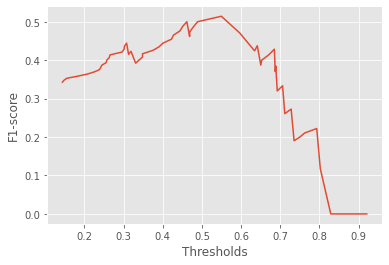

In [31]:
plt.plot(thresholds, f1_scores[:])
plt.xlabel('Thresholds')
plt.ylabel('F1-score')

Text(0.5, 0, 'Thresholds')

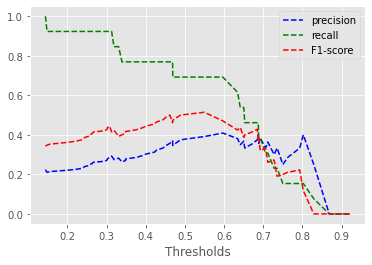

In [32]:
plt.plot(thresholds, precision[:-1], 'b--' , label='precision')
plt.plot(thresholds, recall[:-1], 'g--', label='recall')
plt.plot(thresholds, f1_scores[:], 'r--', label='F1-score')
plt.legend()
plt.xlabel('Thresholds')

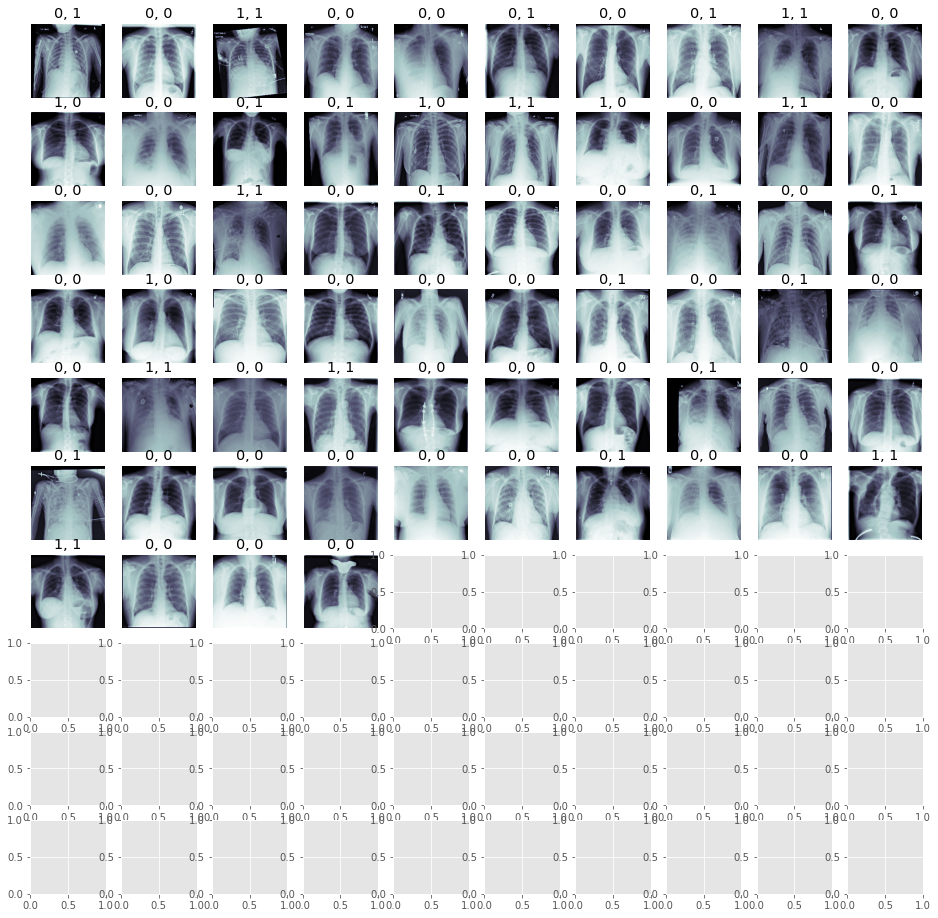

In [33]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresholds[np.argmax(f1_scores)]:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresholds[np.argmax(f1_scores)]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [34]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)